In [9]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
from nba_api.stats.endpoints import playergamelog, leaguedashteamstats
from nba_api.stats.static import players, teams
from _team_stat_helpers import load_team_stats, get_team_rolling_avg, get_latest_team_stat, get_def_vs_avg_scale, get_team_stats_df
from __feature_helpers import enrich_with_adv_player_stats, enrich_current_game_with_adv_stats
#load_team_stats("merged_player_team_adv_stats_2024-25.csv")

In [10]:
load_team_stats("merged_player_team_adv_stats_2024-25.csv")

[✓] Loaded team stats with 34190 rows.


In [11]:
class FeatureBuilder:
    def __init__(self, players_by_team, season='2024-25', rolling_window=5):
        self.players_by_team = players_by_team
        self.season = season
        self.rolling_window = rolling_window
        self.all_player_ids = self._build_player_lookup()
        self.team_abbrev_to_id = self._build_team_abbrev_to_id()
        self.team_advanced_stats = self._fetch_team_advanced_stats()
    
    def _build_player_lookup(self):
        # Get full list of NBA players and map names to IDs
        player_list = players.get_players()
        return {p['full_name']: p['id'] for p in player_list}
    
    def _build_team_abbrev_to_id(self):
        return {t['abbreviation']: t['id'] for t in teams.get_teams()}

    def _fetch_team_advanced_stats(self):
        
        """
        Loads precomputed team stats (already merged with player data) 
        from the CSV-backed global _team_stats_df.
        Returns a dict: {TEAM_ID: {col1: val1, col2: val2, ...}}
        """
        _df = get_team_stats_df()

        if _df is None:
            raise RuntimeError("Team stats not loaded. Call load_team_stats() before initializing FeatureBuilder.")

        _df.columns = _df.columns.str.strip()  # strip whitespace

        # Log column names
        #print("[Debug] Columns in loaded team stats:", _df.columns.tolist())

        # Confirm TEAM_ID is in columns
        if 'TEAM_ID' not in _df.columns:
            raise KeyError("[!] 'TEAM_ID' is missing from loaded team stats. Check CSV or column names.")

        # Drop duplicates and sort
        team_stats_df = _df.drop_duplicates(subset=['GAME_ID', 'TEAM_ID']).copy()
        team_stats_df = team_stats_df.sort_values('GAME_DATE')

        relevant_cols = [
            'TEAM_ID',
            'TEAM_PACE', 'TEAM_OFF_RATING', 'TEAM_AST_PCT',
            'TEAM_E_OFF_RATING', 'TEAM_E_DEF_RATING', 'TEAM_REB_PCT'
        ]
        missing_cols = [col for col in relevant_cols if col not in team_stats_df.columns]
        if missing_cols:
            #print(f"[!] Missing team stat columns: {missing_cols}")
            return {}

        try:
            # Get latest row per team
            latest_by_team = team_stats_df.groupby('TEAM_ID').last()
            return latest_by_team[[col for col in relevant_cols if col != 'TEAM_ID']].to_dict(orient='index')

        except Exception as e:
            print(f"[!] Error building team stats from merged CSV: {e}")
            return {}

    def fetch_game_log(self, player_name):
        player_id = self.all_player_ids.get(player_name)
        if not player_id:
            print(f"[!] Player ID not found for {player_name}")
            return pd.DataFrame()
        try:
            gl = playergamelog.PlayerGameLog(player_id=player_id, season=self.season)
            df = gl.get_data_frames()[0]
            df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'], format='%b %d, %Y', errors='coerce')
            df.sort_values('GAME_DATE', inplace=True)
            df.reset_index(drop=True, inplace=True)
            df.rename(columns={'Player_ID': 'PLAYER_ID'}, inplace=True)
            return df
        except Exception as e:
            print(f"[!] Error fetching log for {player_name}: {e}")
            return pd.DataFrame()
    
    def generate_features(self):
        all_feature_rows = []
        for team, player_list in self.players_by_team.items():
            print(f"\n[+] Processing team: {team}")
            for player_name in player_list:
                print(f"    - Fetching: {player_name}")
                game_log = self.fetch_game_log(player_name)
                if game_log.empty or len(game_log) < self.rolling_window:
                    print(f"      Skipping {player_name}, not enough data.")
                    continue
                
                features = self._calculate_rolling_features(game_log, player_name)
                all_feature_rows.append(features)
                time.sleep(0.6)  # Prevent NBA API timeout
                
        if all_feature_rows:
            return pd.concat(all_feature_rows, ignore_index=True)
        else:
            return pd.DataFrame()

    def _calculate_rolling_features(self, df, player_name):
        feature_rows = []

        def parse_minutes(min_val):
            try:
                if isinstance(min_val, str) and ':' in min_val:
                    parts = min_val.split(':')
                    return int(parts[0]) + int(parts[1]) / 60
                return float(min_val)
            except Exception as e:
                print(f"parse_minutes() failed for: {min_val} with error: {e}")
                return 0

        for i in range(self.rolling_window, len(df)):
            current_game = df.iloc[i].copy()
            past_games = df.iloc[i - self.rolling_window:i].copy()

            try:
                current_game = enrich_current_game_with_adv_stats(current_game)
            except Exception as e:
                print(f"[!] Failed to enrich current_game: {e}")
            try:
                past_games = enrich_with_adv_player_stats(past_games)
            except Exception as e:
                print(f"[!] Failed to enrich past_games: {e}")

            # Team IDs
            opp_abbrev = current_game['MATCHUP'].split(' ')[-1]
            player_team_abbrev = current_game['MATCHUP'].split(' ')[0]
            opp_team_id = self.team_abbrev_to_id.get(opp_abbrev)
            player_team_id = self.team_abbrev_to_id.get(player_team_abbrev)
            usg_pct_current = current_game.get('USG_PCT', np.nan)

            # Team-level rolling stats
            rolling_opp_def_5g = get_team_rolling_avg(opp_team_id, current_game['GAME_DATE'], 'TEAM_DEF_RATING')
            rolling_opp_blocks_5g = get_team_rolling_avg(opp_team_id, current_game['GAME_DATE'], 'TEAM_BLK')
            rolling_opp_steals_5g = get_team_rolling_avg(opp_team_id, current_game['GAME_DATE'], 'TEAM_STL')
            rolling_opp_fouls_5g = get_team_rolling_avg(opp_team_id, current_game['GAME_DATE'], 'TEAM_PF')
            rolling_opp_ast_pct_5g = get_team_rolling_avg(opp_team_id, current_game['GAME_DATE'], 'TEAM_AST_PCT')
            if np.isnan(rolling_opp_ast_pct_5g):
                rolling_opp_ast_pct_5g = np.nan
            rolling_opp_reb_pct_5g = get_team_rolling_avg(opp_team_id, current_game['GAME_DATE'], 'TEAM_REB_PCT')
            if np.isnan(rolling_opp_reb_pct_5g): 
                rolling_opp_reb_pct_5g = np.nan
            rolling_team_off_5g = get_team_rolling_avg(player_team_id, current_game['GAME_DATE'], 'TEAM_OFF_RATING')
            rolling_team_ast_pct_5g = get_team_rolling_avg(player_team_id, current_game['GAME_DATE'], 'TEAM_AST_PCT')
            rolling_team_reb_pct_5g = get_team_rolling_avg(player_team_id, current_game['GAME_DATE'], 'TEAM_REB_PCT')
            latest_team_e_off_rating = get_latest_team_stat(player_team_id, current_game['GAME_DATE'], 'TEAM_E_OFF_RATING')
            latest_opp_e_def_rating = get_latest_team_stat(opp_team_id, current_game['GAME_DATE'], 'TEAM_E_DEF_RATING')
            if np.isnan(latest_opp_e_def_rating):
                latest_opp_e_def_rating = np.nan

            # Defensive mean helper
            def safe_mean(col): return past_games[col].dropna().mean() if col in past_games.columns else np.nan

            # Rolling player-level stats
            rolling_usg_pct_5G = safe_mean('USG_PCT')
            rolling_e_usg_pct_5G = safe_mean('E_USG_PCT')
            rolling_fg_pct_5G = safe_mean('FG_PCT')
            rolling_fg3_pct_5G = safe_mean('FG3_PCT')
            rolling_fga_5G = safe_mean('FGA')
            rolling_poss_5G = safe_mean('POSS')
            rolling_Team_e_pace_5G = safe_mean('TEAM_E_PACE')
            rolling_ast_pct_5G = safe_mean('AST_PCT')
            rolling_oreb_pct_5G = safe_mean('OREB_PCT')
            rolling_dreb_pct_5G = safe_mean('DREB_PCT')
            rolling_reb_pct_5G = safe_mean('REB_PCT')
            rolling_pts_from_3_5g = safe_mean('PTS_3')
            rolling_pts_from_2_5g = safe_mean('PTS_2')
            rolling_pts_from_ft_5g = safe_mean('PTS_FT')
            rolling_looseball_rec_5g = safe_mean('LOOSE_BALLS_RECOVERED')
            rolling_screen_ast_5g = safe_mean('SCREEN_ASSISTS')
            touches_to_pts_ratio = past_games['PTS'].sum() / max(past_games['TCHS'].sum(), 1)
            transition_pts_pct = past_games['PTS_FB'].sum() / max(past_games['PTS'].sum(), 1)

            # Basic stats
            rolling_pts_avg = past_games['PTS'].mean()
            rolling_std = past_games['PTS'].std()
            rolling_3pm_avg = past_games['FG3M'].mean()
            pts_trend_slope_5G = past_games['PTS'].iloc[-1] - past_games['PTS'].iloc[0]

            # MIN handling
            minutes_list = past_games['MIN'].apply(parse_minutes)
            min_avg = minutes_list.mean()
            last_game_min = parse_minutes(df.iloc[i - 1]['MIN'])
            delta_min_vs_rolling = last_game_min - min_avg if last_game_min and min_avg else np.nan

            # Adjusted projections
            def_rating_scale = get_def_vs_avg_scale(opp_team_id, current_game['GAME_DATE'], stat_col='TEAM_DEF_RATING')
            adjusted_pts_proj_def = rolling_pts_avg * (def_rating_scale if not np.isnan(def_rating_scale) else 1.0)
            adjusted_pts_proj_usg = (rolling_pts_avg * (def_rating_scale if not np.isnan(def_rating_scale) else 1.0)
                * (usg_pct_current if not np.isnan(usg_pct_current) else 1.0))

            # Safe guards for ratios
            fga_safe = max(rolling_fga_5G, 1e-5)
            min_safe = max(min_avg, 1e-5)
            pts_safe = max(rolling_pts_avg, 1e-5)
            three_pm_safe = max(rolling_3pm_avg, 1e-5)

            # Ratios
            shots_per_min = rolling_fga_5G / min_safe
            pts_per_fga = rolling_pts_avg / fga_safe
            pts_per_min = rolling_pts_avg / min_safe
            pts_to_3pm_ratio = rolling_pts_avg / three_pm_safe
            ast_to_poss_ratio = rolling_ast_pct_5G / max(rolling_poss_5G, 1e-5)
            usg_to_poss_ratio = rolling_usg_pct_5G / max(rolling_poss_5G, 1e-5)
            engagement_index = (rolling_usg_pct_5G + rolling_ast_pct_5G + rolling_reb_pct_5G) / max(rolling_Team_e_pace_5G, 1e-5)
            volume_efficiency_ratio = rolling_usg_pct_5G * pts_per_fga

            # More deltas
            delta_pts_vs_rolling = df.iloc[i - 1]['PTS'] - rolling_pts_avg
            if rolling_opp_def_5g is not None and latest_opp_e_def_rating is not None and not np.isnan(rolling_opp_def_5g) and not np.isnan(latest_opp_e_def_rating):
                opp_def_trend_delta = latest_opp_e_def_rating - rolling_opp_def_5g
            else:
                opp_def_trend_delta = np.nan
            delta_fg_pct_vs_avg = current_game['FG_PCT'] / rolling_fg_pct_5G
            delta_fga_vs_rolling = current_game['FGA'] / rolling_fga_5G

            # Flags
            is_volume_shooter = int(rolling_fga_5G >= 15)
            is_trending_up = int(pts_trend_slope_5G > 0)
            is_trending_down = int(pts_trend_slope_5G < 0)
            high_efficiency = int(pts_per_fga >= 1.25)

            # Team pacing
            team_stats = self.team_advanced_stats.get(player_team_id, {})
            opp_stats = self.team_advanced_stats.get(opp_team_id, {})
            team_pace = team_stats.get('TEAM_PACE', np.nan)
            opp_pace = opp_stats.get('TEAM_PACE', np.nan)

            
            start_pos = str(current_game.get('START_POSITION', '')).strip().upper()
            is_valid_start = 1.0 if start_pos in ['C', 'F', 'G'] else 0.0

            row ={ 
                'PLAYER_NAME': player_name,
                'PLAYER_ID': current_game['PLAYER_ID'],
                'GAME_DATE': current_game['GAME_DATE'],
                'TEAM_ID': player_team_id,
                'OPP_TEAM_ID': opp_team_id,
                'HOME_AWAY': 0 if '@' in current_game['MATCHUP'] else 1,
                'rolling_pts_avg_5G': rolling_pts_avg,
                'rolling_pts_median_5G': past_games['PTS'].median(),
                'rolling_3pm_avg_5G': rolling_3pm_avg,
                'rolling_3pm_median_5G': past_games['FG3M'].median(),
                'rolling_min_avg_5G': min_avg,
                'rolling_std_pts_5G': rolling_std,
                'pts_consistency_score': rolling_pts_avg / (rolling_std + 1e-5),
                'rest_days': (current_game['GAME_DATE'] - df.iloc[i - 1]['GAME_DATE']).days,
                'is_b2b': int((current_game['GAME_DATE'] - df.iloc[i - 1]['GAME_DATE']).days == 1),
                'rolling_opp_def_rating_5G': rolling_opp_def_5g,
                'rolling_opp_ast_pct_5G': rolling_opp_ast_pct_5g,
                'rolling_opp_blocks_5g': rolling_opp_blocks_5g,
                'rolling_opp_steals_5g': rolling_opp_steals_5g,
                'rolling_opp_fouls_5g': rolling_opp_fouls_5g,
                'rolling_team_off_rating_5G': rolling_team_off_5g,
                'rolling_team_reb_pct_5G': rolling_team_reb_pct_5g,
                'rolling_team_ast_pct_5G': rolling_team_ast_pct_5g,
                'rolling_opp_reb_pct_5G': rolling_opp_reb_pct_5g,
                'latest_team_e_off_rating': latest_team_e_off_rating,
                'latest_opp_e_def_rating': latest_opp_e_def_rating,
                'adjusted_pts_proj_def': adjusted_pts_proj_def,
                'adjusted_pts_proj_usg': adjusted_pts_proj_usg,
                'rolling_usg_pct_5G': rolling_usg_pct_5G,
                'rolling_e_usg_pct_5G': rolling_e_usg_pct_5G,
                'rolling_fg_pct_5G': rolling_fg_pct_5G,
                'rolling_fg3_pct_5G': rolling_fg3_pct_5G,
                'rolling_fga_5G': rolling_fga_5G,
                'delta_pts_vs_rolling': delta_pts_vs_rolling,
                'delta_min_vs_rolling': delta_min_vs_rolling,
                'delta_fga_vs_rolling': delta_fga_vs_rolling,
                'opp_def_trend_delta': opp_def_trend_delta,
                'fg_pct_vs_avg_delta': delta_fg_pct_vs_avg,
                'shots_per_min': shots_per_min,
                'pts_per_fga': pts_per_fga,
                'pts_per_min': pts_per_min,
                'team_pace': team_pace,
                'opp_pace': opp_pace,
                'pts_to_3pm_ratio': pts_to_3pm_ratio,
                'pts_trend_slope_5G': pts_trend_slope_5G,
                'is_volume_shooter': is_volume_shooter,
                'is_trending_up': is_trending_up,
                'is_trending_down': is_trending_down,
                'high_efficiency': high_efficiency,
                'rolling_ast_pct_5G': rolling_ast_pct_5G,
                'rolling_oreb_pct_5G': rolling_oreb_pct_5G,
                'rolling_dreb_pct_5G': rolling_dreb_pct_5G,
                'rolling_reb_pct_5G': rolling_reb_pct_5G,
                'rolling_poss_5g': rolling_poss_5G,
                'ast_to_poss_ratio': ast_to_poss_ratio,
                'usg_to_poss_ratio': usg_to_poss_ratio,
                'engagement_index': engagement_index,
                'volume_efficiency_ratio': volume_efficiency_ratio,
                'starts_as_C': int(start_pos == 'C') if is_valid_start else 0,
                'starts_as_G': int(start_pos == 'G') if is_valid_start else 0,
                'starts_as_F': int(start_pos == 'F') if is_valid_start else 0,
                'is_starter': int(is_valid_start),
                'rolling_pts_from_2_5g': rolling_pts_from_2_5g,
                'rolling_pts_from_3_5g': rolling_pts_from_3_5g,
                'rolling_pts_from_ft_5g': rolling_pts_from_ft_5g,
                'rolling_looseball_rec_5g': rolling_looseball_rec_5g,
                'rolling_screen_ast_5g': rolling_screen_ast_5g,
                'touches_to_pts_ratio': touches_to_pts_ratio,
                'transition_pts_pct': transition_pts_pct,
                'PTS': current_game['PTS']
                }

            feature_rows.append(row)

        return pd.DataFrame(feature_rows)

In [12]:
from ___team_data import players_by_team  # Your custom module

fb = FeatureBuilder(players_by_team, season='2024-25', rolling_window=5)
features_df = fb.generate_features()
#print(features_df.isna().mean().sort_values(ascending=False).head(20))
# Save to CSV
#display(features_df.head(100))
features_df.to_csv("nba_player_features_rolling5G.csv", index=False)

# Preview output 
# print(features_df.head())



[+] Processing team: Celtics
    - Fetching: Jayson Tatum
[!] No advanced stats found for PLAYER_ID 1628369 on 2025-04-11
    - Fetching: Jaylen Brown
    - Fetching: Derrick White
[!] No advanced stats found for PLAYER_ID 1628401 on 2025-04-11
    - Fetching: Jrue Holiday
[!] No advanced stats found for PLAYER_ID 201950 on 2025-04-11
    - Fetching: Payton Pritchard
[!] No advanced stats found for PLAYER_ID 1630202 on 2025-04-11
[!] No advanced stats found for PLAYER_ID 1630202 on 2025-04-13
    - Fetching: Kristaps Porziņģis
[!] No advanced stats found for PLAYER_ID 204001 on 2025-04-11

[+] Processing team: Knicks
    - Fetching: Karl-Anthony Towns
[!] No advanced stats found for PLAYER_ID 1626157 on 2025-04-10
    - Fetching: Jalen Brunson
[!] No advanced stats found for PLAYER_ID 1628973 on 2025-04-10
[!] No advanced stats found for PLAYER_ID 1628973 on 2025-04-11
    - Fetching: OG Anunoby
[!] No advanced stats found for PLAYER_ID 1628384 on 2025-04-11
    - Fetching: Mikal Brid

In [13]:
from scipy.stats import pointbiserialr
from sklearn.feature_selection import mutual_info_classif

def add_threshold_targets(df):
    df['hit_10pts'] = (df['rolling_pts_avg_5G'] >= 10).astype(int)
    df['hit_15pts'] = (df['rolling_pts_avg_5G'] >= 15).astype(int)
    df['hit_20pts'] = (df['rolling_pts_avg_5G'] >= 20).astype(int)
    df['hit_25pts'] = (df['rolling_pts_avg_5G'] >= 25).astype(int)
    return df

def compute_pointbiserial_correlations(df, target_col, feature_cols):
    print(f"\n--- Correlation with: {target_col} ---")
    for feature in feature_cols:
        try:
            corr, p = pointbiserialr(df[target_col], df[feature])
            print(f"{feature:<30} -> Corr: {corr:.4f} (p={p:.4f})")
        except Exception as e:
            print(f"{feature:<30} -> ERROR: {e}")

def compute_mutual_info(df, target_col, feature_cols):
    print(f"\n--- Mutual Info with: {target_col} ---")
    X = df[feature_cols].fillna(0)
    y = df[target_col]
    mi = mutual_info_classif(X, y, discrete_features=False, random_state=42)
    for feat, score in zip(feature_cols, mi):
        print(f"{feat:<30} -> MI Score: {score:.4f}")

In [14]:
features_df = add_threshold_targets(features_df)

important_features = [
    'rolling_pts_avg_5G', 'rolling_pts_median_5G', 'rolling_3pm_avg_5G', 'rolling_3pm_median_5G', 'rolling_min_avg_5G', 'rolling_std_pts_5G',  
    'pts_consistency_score', 'rolling_opp_def_rating_5G', 'rolling_opp_ast_pct_5G', 'rolling_team_off_rating_5G', 
    'rolling_team_reb_pct_5G', 'rolling_team_ast_pct_5G', 'rolling_opp_reb_pct_5G', 'latest_team_e_off_rating',
    'latest_opp_e_def_rating', 'adjusted_pts_proj_def', 'rolling_usg_pct_5G', 'rolling_fg_pct_5G',     
    'rolling_fg3_pct_5G', 'rolling_fga_5G', 'delta_pts_vs_rolling', 'delta_min_vs_rolling',          
    'opp_def_trend_delta', 'adjusted_pts_proj_usg', 'rest_days', 'is_b2b', 'team_pace', 'opp_pace',
    'shots_per_min', 'pts_per_fga', 'pts_per_min', 'pts_to_3pm_ratio', 'pts_trend_slope_5G', 'is_volume_shooter', 
    'is_trending_up', 'is_trending_down', 'high_efficiency', 'rolling_ast_pct_5G', 'rolling_oreb_pct_5G', 'rolling_dreb_pct_5G',
    'rolling_reb_pct_5G', 'ast_to_poss_ratio', 'usg_to_poss_ratio', 'engagement_index', 'volume_efficiency_ratio', 'starts_as_C',
    'starts_as_G', 'starts_as_F', 'is_starter', 'HOME_AWAY', 'fg_pct_vs_avg_delta', 'delta_fga_vs_rolling',
    'rolling_pts_from_2_5g', 'rolling_pts_from_3_5g', 'rolling_pts_from_ft_5g', 'rolling_looseball_rec_5g', 'rolling_screen_ast_5g', 
    'touches_to_pts_ratio', 'transition_pts_pct','rolling_opp_blocks_5g', 'rolling_opp_steals_5g', 'rolling_opp_fouls_5g'
]

features_df[['PLAYER_NAME', 'GAME_DATE', 'rolling_pts_avg_5G', 'hit_15pts']].head()

compute_pointbiserial_correlations(features_df, 'hit_10pts', important_features)
compute_pointbiserial_correlations(features_df, 'hit_15pts', important_features)
compute_pointbiserial_correlations(features_df, 'hit_20pts', important_features)
compute_pointbiserial_correlations(features_df, 'hit_25pts', important_features)
compute_mutual_info(features_df, 'hit_10pts', important_features)
compute_mutual_info(features_df, 'hit_15pts', important_features)
compute_mutual_info(features_df, 'hit_20pts', important_features)
compute_mutual_info(features_df, 'hit_25pts', important_features)



--- Correlation with: hit_10pts ---
rolling_pts_avg_5G             -> Corr: 0.5105 (p=0.0000)
rolling_pts_median_5G          -> Corr: 0.4935 (p=0.0000)
rolling_3pm_avg_5G             -> Corr: 0.2516 (p=0.0000)
rolling_3pm_median_5G          -> Corr: 0.2318 (p=0.0000)
rolling_min_avg_5G             -> Corr: 0.5389 (p=0.0000)
rolling_std_pts_5G             -> Corr: 0.2085 (p=0.0000)
pts_consistency_score          -> Corr: 0.2205 (p=0.0000)
rolling_opp_def_rating_5G      -> Corr: -0.0008 (p=0.9831)
rolling_opp_ast_pct_5G         -> Corr: -0.0551 (p=0.1272)
rolling_team_off_rating_5G     -> Corr: 0.0328 (p=0.3633)
rolling_team_reb_pct_5G        -> Corr: 0.0139 (p=0.6997)
rolling_team_ast_pct_5G        -> Corr: 0.0127 (p=0.7242)
rolling_opp_reb_pct_5G         -> Corr: 0.0609 (p=0.0913)
latest_team_e_off_rating       -> Corr: 0.0281 (p=0.4363)
latest_opp_e_def_rating        -> Corr: -0.0012 (p=0.9734)
adjusted_pts_proj_def          -> Corr: 0.5105 (p=0.0000)
rolling_usg_pct_5G             -

C:\Users\chrism\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_stats_py.py:5657: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


rolling_pts_avg_5G             -> MI Score: 0.3203
rolling_pts_median_5G          -> MI Score: 0.2284
rolling_3pm_avg_5G             -> MI Score: 0.0618
rolling_3pm_median_5G          -> MI Score: 0.0566
rolling_min_avg_5G             -> MI Score: 0.1416
rolling_std_pts_5G             -> MI Score: 0.0425
pts_consistency_score          -> MI Score: 0.0559
rolling_opp_def_rating_5G      -> MI Score: 0.0000
rolling_opp_ast_pct_5G         -> MI Score: 0.0000
rolling_team_off_rating_5G     -> MI Score: 0.0000
rolling_team_reb_pct_5G        -> MI Score: 0.0000
rolling_team_ast_pct_5G        -> MI Score: 0.0000
rolling_opp_reb_pct_5G         -> MI Score: 0.0000
latest_team_e_off_rating       -> MI Score: 0.0000
latest_opp_e_def_rating        -> MI Score: 0.0000
adjusted_pts_proj_def          -> MI Score: 0.3203
rolling_usg_pct_5G             -> MI Score: 0.1015
rolling_fg_pct_5G              -> MI Score: 0.0923
rolling_fg3_pct_5G             -> MI Score: 0.0163
rolling_fga_5G                 

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X = features_df[important_features].fillna(0)
y = features_df['hit_15pts']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = LogisticRegression(max_iter=1500)
model.fit(X_train, y_train)
preds = model.predict(X_test)

print(classification_report(y_test, preds))


              precision    recall  f1-score   support

           0       0.94      0.97      0.95        63
           1       0.98      0.97      0.98       130

    accuracy                           0.97       193
   macro avg       0.96      0.97      0.96       193
weighted avg       0.97      0.97      0.97       193



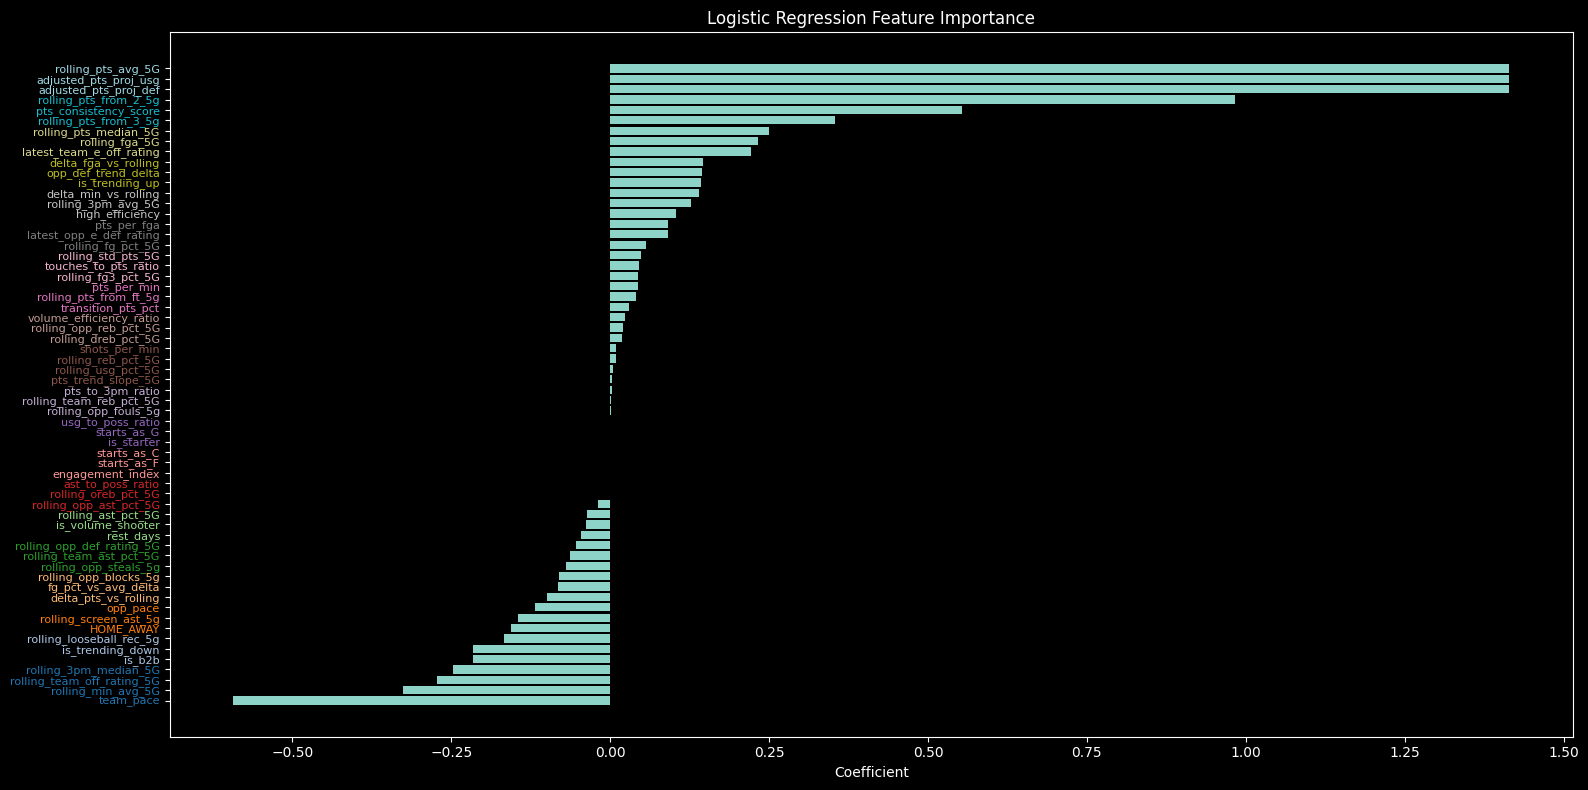

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("dark_background")
plt.rcParams.update({'figure.autolayout': True})

importance = model.coef_[0]

# Sort importance + features together, descending
important_features = np.array(important_features)
sorted_idx = np.argsort(importance)
importance = importance[sorted_idx]
important_features = important_features[sorted_idx]

fig, ax = plt.subplots(figsize=(16, 8))
bars = ax.barh(important_features, importance)

# Apply gradient to Y-axis labels
cmap = plt.get_cmap('tab20')
num_labels = len(important_features)
colors = [cmap(i / num_labels) for i in range(num_labels)]

# Set each tick label's color individually
ax.set_yticks(np.arange(len(important_features)))
ax.set_yticklabels(important_features)
for label, color in zip(ax.get_yticklabels(), colors):
    label.set_color(color)
    label.set_fontsize(8)

plt.title('Logistic Regression Feature Importance')
plt.xlabel('Coefficient')
plt.show()
